# 230117_1424_확인

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd "/content/drive/My Drive/Colab Notebooks/code_240116_0133"

In [1]:
# 파이썬 버전 확인
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 버전 확인
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 버전 확인
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# colab 사용여부 판단
try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# GPU 사용 여부 판단
if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial

# 난수 지정
# 시드를 42로 지정하여 모든 실행결과에서 시드42의 난수를 생성하도록 지정
# 노트북 실행 결과를 동일하게 유지
np.random.seed(42)
tf.random.set_seed(42)

# 그래프 출력 설정
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# 정확도 계산 함수
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

'''
모델의 이진 분류 작업에 사용할 수 있는 평가 지표
실제 정답과 예측값을 반올림하여 정확도를 계산
예측값이 실수 형태로 주어지더라도 이진 분류 작업에서의 정확도 평가 가능

y_true(정답값) 및 y_pred(예측값) 두 개의 인자를 받음

tf.round()를 사용하여 실제 정답값과 예측값을 반올림하여 예측된 클래스를 이진형태로 변환(0 또는 1)

keras.metrics.binary_accuracy 함수를 사용하여
반올림된 실제 정답값과 반올림된 예측값 사이의 이진 분류 정확도(binary accuracy)를 계산
'''

'\n모델의 이진 분류 작업에 사용할 수 있는 평가 지표\n실제 정답과 예측값을 반올림하여 정확도를 계산\n예측값이 실수 형태로 주어지더라도 이진 분류 작업에서의 정확도 평가 가능\n\ny_true(정답값) 및 y_pred(예측값) 두 개의 인자를 받음\n\ntf.round()를 사용하여 실제 정답값과 예측값을 반올림하여 예측된 클래스를 이진형태로 변환(0 또는 1)\n\nkeras.metrics.binary_accuracy 함수를 사용하여\n반올림된 실제 정답값과 반올림된 예측값 사이의 이진 분류 정확도(binary accuracy)를 계산\n'

load complete


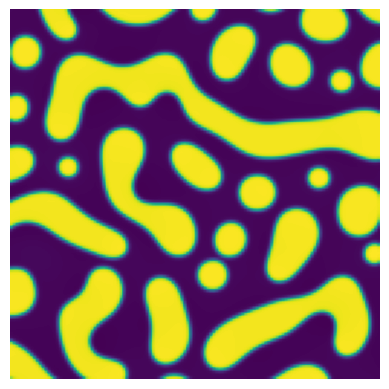

================= shape ==================
X_train: (80, 128, 128, 1)
X_valid: (20, 128, 128, 1)
X_test : (100, 128, 128, 1)

================= type ==================
X_train: <class 'numpy.ndarray'>
X_valid: <class 'numpy.ndarray'>
X_test : <class 'numpy.ndarray'>



In [3]:
# AE에 사용할 LTME 데이터를 불러오기
def LTME_data_load():
    with open('Data_set_LTME/X_train.pkl', 'rb') as file:
        X_train = pickle.load(file)
    with open('Data_set_LTME/X_valid.pkl', 'rb') as file:
        X_valid = pickle.load(file)
    with open('Data_set_LTME/X_test.pkl', 'rb') as file:
        X_test  = pickle.load(file)
    print('load complete')

    X_train = X_train[..., np.newaxis]
    X_valid = X_valid[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]
    return X_train, X_valid, X_test

X_train, X_valid, X_test = LTME_data_load()

########## 데이터 형태 확인하기 ##########
plt.imshow(X_train[0]) #, cmap='gray')
plt.axis('off')
plt.show()
print('================= shape ==================') 
print('X_train:', np.shape(X_train))
print('X_valid:', np.shape(X_valid))
print('X_test :', np.shape(X_test))
print()
print('================= type ==================') 
print('X_train:', type(X_train))
print('X_valid:', type(X_valid))
print('X_test :', type(X_test))
print()
print('============================================')

In [4]:
# AE 모델 생성

def make_ae_model():

    ########## 난수 지정 ##########
    tf.random.set_seed(42)
    np.random.seed(42)

    ########## ?????? ##########
    DefaultConv2D = partial(
        keras.layers.Conv2D,
        kernel_size=3,
        activation='relu',
        padding="SAME")

    ########## convolution ##########
    convolution = keras.models.Sequential([
        DefaultConv2D(filters=16, kernel_size=3, input_shape=[128, 128, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=8),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=4),
        keras.layers.MaxPooling2D(pool_size=2),
    ])

    ########## 인코더 생성 ##########
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[16, 16, 4]),
        keras.layers.Dense(196),
    ])

    ########## 디코더 생성 ##########
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(16*16*4, activation="relu", input_shape=[196]),
        keras.layers.Reshape([16, 16, 4])
    ])

    ########## transpose convolution ##########
    transpose_convolution = keras.models.Sequential([
        DefaultConv2D(filters=4, kernel_size=3, input_shape=[16, 16, 4]),
        keras.layers.UpSampling2D(size=(2, 2)),
        DefaultConv2D(filters=8),
        keras.layers.UpSampling2D(size=(2, 2)),
        DefaultConv2D(filters=16),
        keras.layers.UpSampling2D(size=(2, 2)),
        DefaultConv2D(filters=1),
    ])

    convolution.summary()
    stacked_encoder.summary()
    stacked_decoder.summary()
    transpose_convolution.summary()

    ########## 오토인코더 모델 생성 ##########
    # 인코더와 디코더를 합쳐서 하나의 오토인코더 모델을 생성
    ae_model = keras.models.Sequential([convolution, stacked_encoder, stacked_decoder, transpose_convolution])

    ########## 모델 컴파일 후 반환 ##########
    ae_model.compile(
        loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-4),
        metrics=[rounded_accuracy])
    convolution.summary()
    stacked_encoder.summary()
    stacked_decoder.summary()
    transpose_convolution.summary()
    return ae_model


ae_model = make_ae_model()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-01-17 13:53:11.642236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 13:53:11.642561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 4)         292       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 4)        0

In [5]:
# # AE 모델 생성
# def make_ae_model():

#     ########## 난수 지정 ##########
#     tf.random.set_seed(42)
#     np.random.seed(42)

#     ########## 인코더 생성 ##########
#     stacked_encoder = keras.models.Sequential([
#         keras.layers.Flatten(input_shape=[28, 28]),
#         keras.layers.Dense(100, activation="selu"),
#         keras.layers.Dense(30, activation="selu"),])

#     ########## 디코더 생성 ##########
#     stacked_decoder = keras.models.Sequential([
#         keras.layers.Dense(100, activation="selu", input_shape=[30]),
#         keras.layers.Dense(28 * 28, activation="sigmoid"),
#         keras.layers.Reshape([28, 28])])

#     ########## 오토인코더 모델 생성 ##########
#     # 인코더와 디코더를 합쳐서 하나의 오토인코더 모델을 생성
#     ae_model = keras.models.Sequential([stacked_encoder, stacked_decoder])

#     ########## 모델 컴파일 후 반환 ##########
#     ae_model.compile(
#         loss="binary_crossentropy",
#         optimizer=keras.optimizers.SGD(learning_rate=1.5),
#         metrics=[rounded_accuracy])
#     stacked_encoder.summary()
#     stacked_decoder.summary()
#     return ae_model



# ae_model = make_ae_model()

In [5]:
# AE 모델을 학습
def train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path):

    ########## AE 모델 학습 ##########
    ae_history = ae_model.fit(X_train, X_train, epochs=epochs_num, validation_data=(X_valid, X_valid))

    ########## AE 모델 학습기록 및 결과 저장 ##########
    ae_model.save(model_path)
    with open(hist_path, 'wb') as file:
        pickle.dump(ae_history.history, file)

    return ae_history, ae_model



epochs_num = 20
model_path = 'ckpt_AE_LTME_model'
hist_path  = 'ckpt_AE_LTME_hist'
ae_history, ae_model = train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path)

Epoch 1/20


2024-01-17 13:53:13.865628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-17 13:53:14.270630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 mus

2/3 [===================>..........] - ETA: 0s - loss: 0.5435 - rounded_accuracy: 0.0268 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x1xi1>'


3/3 [==============================] - ETA: 0s - loss: 0.6284 - rounded_accuracy: 0.0257

2024-01-17 13:53:19.973704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 7s 661ms/step - loss: 0.6284 - rounded_accuracy: 0.0257 - val_loss: 2.5521 - val_rounded_accuracy: 0.0169
Epoch 2/20
3/3 [==============================] - 0s 105ms/step - loss: 0.0971 - rounded_accuracy: 0.0257 - val_loss: 1.9905 - val_rounded_accuracy: 0.0169
Epoch 3/20
3/3 [==============================] - 0s 87ms/step - loss: -0.4167 - rounded_accuracy: 0.0257 - val_loss: 1.4254 - val_rounded_accuracy: 0.0169
Epoch 4/20
3/3 [==============================] - 0s 79ms/step - loss: -0.8445 - rounded_accuracy: 0.0257 - val_loss: 0.9306 - val_rounded_accuracy: 0.0169
Epoch 5/20
3/3 [==============================] - 0s 80ms/step - loss: -1.1958 - rounded_accuracy: 0.0257 - val_loss: 0.5407 - val_rounded_accuracy: 0.0169
Epoch 6/20
3/3 [==============================] - 0s 94ms/step - loss: -1.4808 - rounded_accuracy: 0.0257 - val_loss: 0.2373 - val_rounded_accuracy: 0.0169
Epoch 7/20
3/3 [==============================] - 0s 106ms/step - loss: -1.

INFO:tensorflow:Assets written to: ckpt_CNN_LTME_model/assets


INFO:tensorflow:Assets written to: ckpt_CNN_LTME_model/assets


In [6]:
# AE 모델 검증
# loss, accuracy
ae_model.evaluate(X_test, X_test)

4/4 [==============================] - 1s 217ms/step - loss: 2.4802 - rounded_accuracy: 0.0321


[2.4801712036132812, 0.03210632503032684]

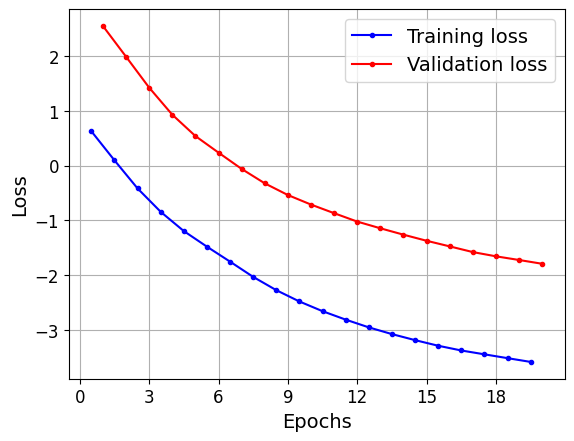

In [7]:
# loss 그래프를 그리는 함수
# 학습하는 동안의 loss의 변화를 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()



# 학습하는 동안의 loss의 변화를 시각화
plot_learning_curves(ae_history.history["loss"], ae_history.history["val_loss"])

1/1 [==============================] - 0s 75ms/step


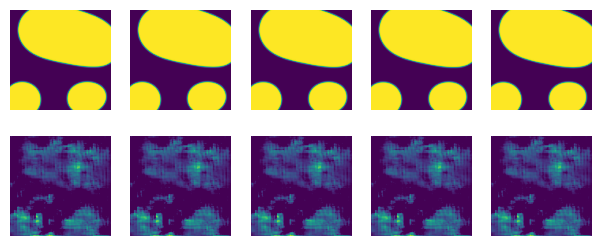

In [10]:
# 학습한 모델로 이미지 재구성
def result_show(ae_model, X_valid, num_samples):

    ########## 이미지 재구성 ##########
    # X_valid안에서 원하는 양만큼의 이미지를 재구성
    #            X_valid : (5000, 28, 28)
    # X_valid[:show_num] : (5, 28, 28)      # 본 코드에서는 5개 선택
    #    reconstructions : (5, 28, 28)
    reconstructions = ae_model.predict(X_valid[:num_samples])

    ########## 결과 시각화 ##########
    # 윗줄은 원본 이미지
    # 아래줄은 재구성 이미지
    plt.figure(figsize=(num_samples * 1.5, 3))
    for image_index in range(num_samples):
        plt.subplot(2, num_samples, 1 + image_index)
        plt.imshow(X_valid[image_index]) #, cmap="binary")
        plt.axis("off")
        plt.subplot(2, num_samples, 1 + num_samples + image_index)
        plt.imshow(reconstructions[image_index]) #, cmap="binary")
        plt.axis("off")
    plt.show()


# X_train X_valid X_test
num_samples = 5
result_show(ae_model, X_valid, num_samples)

1/1 [==============================] - 1s 1s/step


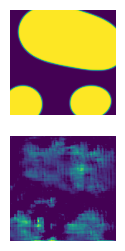

In [11]:
# 학습한 모델을 이용하여 이미지 하나만 재구성하는 방법 
def result_show_one(ae_model, X_valid, show_index):

    ########## 재구성할 이미지 선택 ##########
    test_image = X_valid[show_index]
    test_image = np.array([test_image])

    ########## 이미지 재구성 ##########
    #     test image : (1, 28, 28)
    # reconstruction : (1, 28, 28)
    reconstruction = ae_model.predict(test_image)

    ########## 결과 시각화 ##########
    plt.figure(figsize=(6, 3))
    plt.subplot(211)
    plt.imshow(X_valid[show_index]) #, cmap="binary")
    plt.axis("off")
    plt.subplot(212)
    plt.imshow(reconstruction[0]) #, cmap="binary")
    plt.axis("off")
    plt.show()



show_index = 0
result_show_one(ae_model, X_valid, show_index)

# 런타임 재시작

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functools import partial
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def LTME_data_load():
    with open('Data_set_LTME/X_train.pkl', 'rb') as file:
        X_train = pickle.load(file)
    with open('Data_set_LTME/X_valid.pkl', 'rb') as file:
        X_valid = pickle.load(file)
    with open('Data_set_LTME/X_test.pkl', 'rb') as file:
        X_test  = pickle.load(file)
    print('load complete')
    X_train = X_train[..., np.newaxis]
    X_valid = X_valid[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]
    return X_train, X_valid, X_test

def make_ae_model():
    tf.random.set_seed(42)
    np.random.seed(42)
    DefaultConv2D = partial(
        keras.layers.Conv2D,
        kernel_size=3,
        activation='relu',
        padding="SAME")
    convolution = keras.models.Sequential([
        DefaultConv2D(filters=16, kernel_size=3, input_shape=[128, 128, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=8),
        keras.layers.MaxPooling2D(pool_size=2),
        DefaultConv2D(filters=4),
        keras.layers.MaxPooling2D(pool_size=2),
    ])
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[16, 16, 4]),
        keras.layers.Dense(196),
    ])
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(16*16*4, activation="relu", input_shape=[196]),
        keras.layers.Reshape([16, 16, 4])
    ])
    transpose_convolution = keras.models.Sequential([
        DefaultConv2D(filters=4, kernel_size=3, input_shape=[16, 16, 4]),
        keras.layers.UpSampling2D(size=(2, 2)),
        DefaultConv2D(filters=8),
        keras.layers.UpSampling2D(size=(2, 2)),
        DefaultConv2D(filters=16),
        keras.layers.UpSampling2D(size=(2, 2)),
        DefaultConv2D(filters=1),
    ])
    convolution.summary()
    stacked_encoder.summary()
    stacked_decoder.summary()
    transpose_convolution.summary()
    ae_model = keras.models.Sequential([convolution, stacked_encoder, stacked_decoder, transpose_convolution])
    ae_model.compile(
        loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.Adam(learning_rate = 10**-4),
        metrics=[rounded_accuracy])
    convolution.summary()
    stacked_encoder.summary()
    stacked_decoder.summary()
    transpose_convolution.summary()
    return ae_model

def train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path):
    ae_history = ae_model.fit(X_train, X_train, epochs=epochs_num, validation_data=(X_valid, X_valid))
    ae_model.save(model_path)
    with open(hist_path, 'wb') as file:
        pickle.dump(ae_history.history, file)
    return ae_history, ae_model

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def result_show(ae_model, X_valid, num_samples):
    reconstructions = ae_model.predict(X_valid[:num_samples])
    plt.figure(figsize=(num_samples * 1.5, 3))
    for image_index in range(num_samples):
        plt.subplot(2, num_samples, 1 + image_index)
        plt.imshow(X_valid[image_index])
        plt.axis("off")
        plt.subplot(2, num_samples, 1 + num_samples + image_index)
        plt.imshow(reconstructions[image_index])
        plt.axis("off")
    plt.show()

def result_show_one(ae_model, X_valid, show_index):
    test_image = X_valid[show_index]
    test_image = np.array([test_image])
    reconstruction = ae_model.predict(test_image)
    plt.figure(figsize=(6, 3))
    plt.subplot(211)
    plt.imshow(X_valid[show_index])
    plt.axis("off")
    plt.subplot(212)
    plt.imshow(reconstruction[0])
    plt.axis("off")
    plt.show()

load complete
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-01-17 14:24:25.732799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 14:24:25.733201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 4)         292       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 4)        0

2024-01-17 14:24:26.221337: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-17 14:24:26.610787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 mus

3/3 [==============================] - ETA: 0s - loss: 0.6284 - rounded_accuracy: 0.0257

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x1xi1>'
2024-01-17 14:24:27.970652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enab

3/3 [==============================] - 2s 385ms/step - loss: 0.6284 - rounded_accuracy: 0.0257 - val_loss: 2.5521 - val_rounded_accuracy: 0.0169
Epoch 2/20
3/3 [==============================] - 0s 102ms/step - loss: 0.0971 - rounded_accuracy: 0.0257 - val_loss: 1.9905 - val_rounded_accuracy: 0.0169
Epoch 3/20
3/3 [==============================] - 0s 97ms/step - loss: -0.4167 - rounded_accuracy: 0.0257 - val_loss: 1.4254 - val_rounded_accuracy: 0.0169
Epoch 4/20
3/3 [==============================] - 0s 76ms/step - loss: -0.8445 - rounded_accuracy: 0.0257 - val_loss: 0.9306 - val_rounded_accuracy: 0.0169
Epoch 5/20
3/3 [==============================] - 0s 77ms/step - loss: -1.1958 - rounded_accuracy: 0.0257 - val_loss: 0.5407 - val_rounded_accuracy: 0.0169
Epoch 6/20
3/3 [==============================] - 0s 83ms/step - loss: -1.4808 - rounded_accuracy: 0.0257 - val_loss: 0.2373 - val_rounded_accuracy: 0.0169
Epoch 7/20
3/3 [==============================] - 0s 82ms/step - loss: -1.7

INFO:tensorflow:Assets written to: ckpt_AE_LTME_model/assets


INFO:tensorflow:Assets written to: ckpt_AE_LTME_model/assets


4/4 [==============================] - 0s 73ms/step - loss: 2.4802 - rounded_accuracy: 0.0321


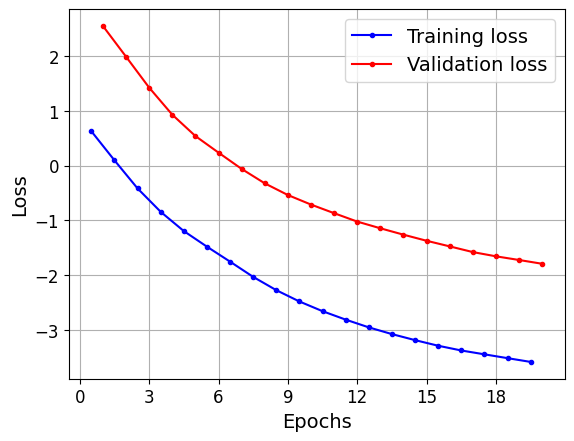

1/1 [==============================] - 0s 211ms/step


2024-01-17 14:24:35.492778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


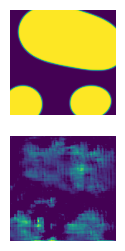

1/1 [==============================] - 0s 105ms/step


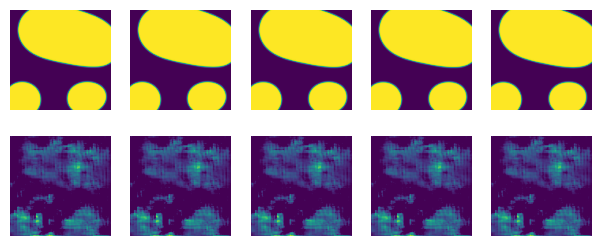

In [2]:
# 전체 한번에 실행

epochs_num = 20
num_samples = 5
show_index = 0
model_path = 'ckpt_AE_LTME_model'
hist_path  = 'ckpt_AE_LTME_hist'

# 데이터
X_train, X_valid, X_test = LTME_data_load() # LTME 데이터 불러오기

# 학습
ae_model = make_ae_model() # AE 모델 생성
ae_history, ae_model = train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path) # AE 모델 학습 ############
ae_model.evaluate(X_test, X_test) # AE 모델 검증

# 학습기록
plot_learning_curves(ae_history.history["loss"], ae_history.history["val_loss"]) # loss 그래프 그리기

# 이미지 재구성
result_show_one(ae_model, X_valid, show_index)
result_show(ae_model, X_valid, num_samples)

load complete
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 4)         292       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16,

2024-01-17 14:24:40.512538: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ckpt_AE_LTME_model: FAILED_PRECONDITION: ckpt_AE_LTME_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2024-01-17 14:24:40.737462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 72ms/step - loss: 2.4802 - rounded_accuracy: 0.0321


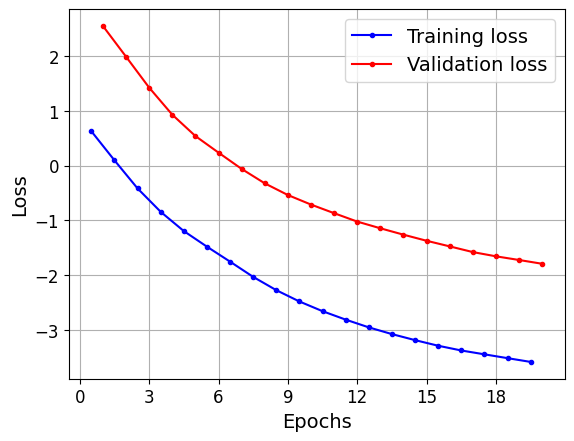

1/1 [==============================] - 0s 179ms/step


2024-01-17 14:24:41.430827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


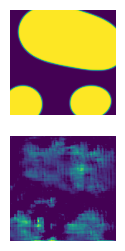

1/1 [==============================] - 0s 96ms/step


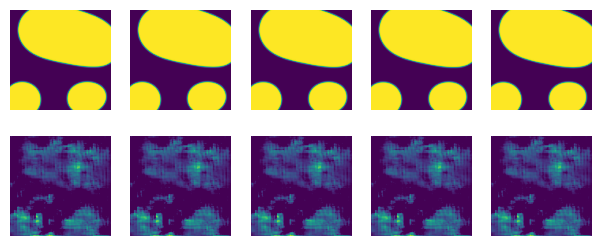

In [3]:
# 기존에 저장한 AE 모델 사용

num_samples = 5
show_index = 0
model_path = 'ckpt_AE_LTME_model'
hist_path  = 'ckpt_AE_LTME_hist'

# 데이터
X_train, X_valid, X_test = LTME_data_load() # LTME 데이터 불러오기

# 학습
new_ae_model = make_ae_model() # AE 모델 생성
new_ae_model.load_weights(model_path) # AE 모델 불러오기 ############
new_ae_model.evaluate(X_test, X_test) # AE 모델 검증

# 학습기록
new_ae_history = pickle.load(open(hist_path, "rb"))
plot_learning_curves(new_ae_history["loss"], new_ae_history["val_loss"]) # loss 그래프 그리기

# 이미지 재구성
result_show_one(new_ae_model, X_valid, show_index)
result_show(new_ae_model, X_valid, num_samples)